In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn
import math
import matplotlib.pyplot as plt
import time


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from pandas import DataFrame

# Initial Evaluation of Classifiers

In [3]:
# read in neccessary data
train_labels = pd.read_csv("train_labels.csv")
train_features = pd.read_csv("train_features.csv")
valid_labels = pd.read_csv("valid_labels.csv")
valid_features = pd.read_csv("valid_features.csv")
test_features = pd.read_csv("test_features.csv")
trackID =  test_features['trackID'].tolist()

In [4]:
#function that splits the data into the subsets audio, metadata, both combined,  labels in both string and discretised form as 
# well as the track ID's
def preprocess(features, labels):
    
    text = features['tags'].tolist()
    
    md = features.iloc[:,2:9] # when combining both data change 9 to 157
    md_new = md.drop(['tags'],axis=1)
    metadata = md_new.values.tolist()
    
    audio = features.iloc[:,9:157]
    audio = audio.values.tolist()
    just_labels = labels.drop(['trackID'], axis=1)
    numeric_labels = just_labels
    just_labels = just_labels.values.tolist()
    just_labels = [val for sublist in just_labels for val in sublist]
    
    for d in list(numeric_labels):
        vals = sorted(set([v for v in numeric_labels[d].values]))
        vals_dict = dict(zip(vals, range(len(vals))))
        numeric_labels[d] =  numeric_labels[d].map(lambda s: vals_dict.get(s) if s in vals_dict else s)
    numeric_labels = numeric_labels.values.tolist()
    numeric_labels = [val for sublist in numeric_labels for val in sublist]
    
    trackID =  features.iloc[:,0]
    trackID = trackID.values.tolist()
    
    return  metadata, audio, just_labels,  numeric_labels, trackID




In [5]:
train_data = preprocess(train_features, train_labels)
valid_data = preprocess(valid_features, valid_labels)
test_data =  preprocess(test_features, valid_labels)



In [555]:
# code to cycle through number of nearest neighbour finding the highest accuracy
i=0
k = [0] * len(range(1, 21))
acc = [0] * len(range(1, 21))
for x in range(1, 21): 
    classifier = KNeighborsClassifier(n_neighbors=x)
    classifier.fit(train_data[0], train_data[2])
    preds = classifier.predict(valid_data[0])
    Acc = metrics.accuracy_score(valid_data[2],preds)
    k[i]=x
    acc[i] = Acc
    i=i+1
Acc_Knn = acc[np.argmax(acc)]

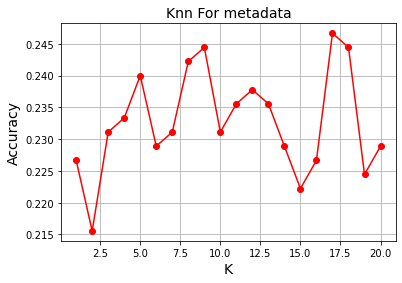

In [556]:
#plot
plt.plot(k, acc, color='red', marker='o')
plt.title('Knn For metadata', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.show()

In [126]:
# Find Accuracy of GNB
GausNB = GaussianNB()
GausNB.fit(train_data[0],train_data[2])
pred = GausNB.predict(valid_data[0])
Acc_GNB = metrics.accuracy_score(valid_data[2], pred)
Acc_GNB

0.5066666666666667

In [74]:
# 0-R
pred = [np.bincount(train_data[5]).argmax()] * len(valid_data[3])
Acc_0R= metrics.accuracy_score(valid_data[4], pred)
Acc_0R

0.12222222222222222

In [75]:
#logistic Regression
lgr = LogisticRegression(max_iter=10000)
lgr.fit(train_data[0],train_data[2])
pred = lgr.predict(valid_data[0])
Acc_lgr = metrics.accuracy_score(valid_data[2], pred)

C:\Users\61431\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
# code to cycle through number of hidden layers finding the highest accuracy for MLP
i=0
iters = [0] * 10
acc = [0] * 10
acc_cv = [0] * 10
start = time.time()
for x in range(10, 110, 10): 
    clf = MLPClassifier(max_iter= 1000, random_state= 1, hidden_layer_sizes = [x])
    clf.fit(train_data[0], train_data[2])
    pred = clf.predict(valid_data[0])
    Acc = metrics.accuracy_score(valid_data[2], pred)
    iters[i]=x
    acc[i] = Acc
    
    i=i+1
end = time.time()
t = end - start
Acc_mlp = acc[np.argmax(acc)]    

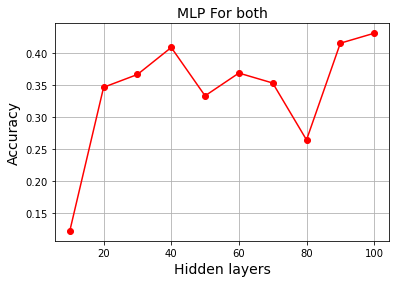

In [82]:
# plot
plt.plot(iters, acc, color='red', marker='o')
plt.title('MLP For both', fontsize=14)
plt.xlabel('Hidden layers', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.show()

In [79]:
# Store accuracies from different classifiers
Y= [Acc_Knn, Acc_GNB, Acc_0R, Acc_lgr, Acc_mlp]
X= ["Knn", "GNB", "0-R", "LGR", "MLP"]


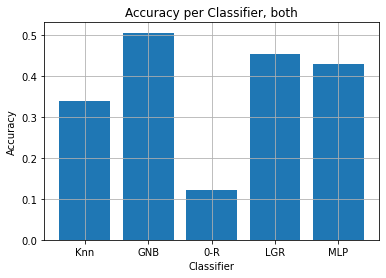

In [83]:
# Plot The classifier accuracies against eachother
plt.bar(X ,Y)
plt.title('Accuracy per Classifier, both')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [591]:
# Find error and error reduction rate
Er = [1] * 5
Err = [0] * 5
for i in range (0, len(Er)):
    Er[i] = Er[i] - Y[i]
    Err[i] = (Er[0]-Er[i])/Er[0]

In [9]:
# Pass in training data and classifier that you want to use
def train(X, Y, clf):
    fit = clf.fit(X, Y)
    return fit

In [10]:
# Pass in training data, the data you want to make predictions on and classifier that you want to use
def predict(X_train,Y_train, X_test, clf):
    clf = train(X_train, Y_train, clf)
    pred = clf.predict(X_test)
    return pred

In [1]:
# makes predictions and writes them into data frame along with the corresponding
# track ID which can then be exported to csv file
#produces best result when GNB is trained with both meta and Audio data. 
pred = predict(train_data[0], train_data[2], test_data[0], GaussianNB())
pred = pred.tolist()
data = {"trackID":test_data[4],"genre":pred}
df = pd.DataFrame(data)


NameError: name 'predict' is not defined

# Feature Evaluation

In [312]:
# takes the meta data and returns a list with meta dats with one feature removed
def drop_one(features):
    
    
    md = features.iloc[:,3:9] # when combining both data change 9 to 157
    loud = md.drop(['loudness'],axis=1)
    loud = loud.values.tolist()
    temp = md.drop(['tempo'],axis=1) 
    temp = temp.values.tolist()
    timesig = md.drop(['time_signature'],axis=1)
    timesig = timesig.values.tolist()
    key = md.drop(['key'],axis=1)
    key = key.values.tolist()
    mode = md.drop(['mode'],axis=1)
    mode = mode.values.tolist()
    duration = md.drop(['duration'],axis=1)
    duration = duration.values.tolist()
    md = md.values.tolist()
    return  md, loud, temp, timesig, key, mode, duration

In [315]:
D1_train =drop_one(train_features)
D1_test = drop_one(valid_features)

In [594]:
# Find Accuracy of each modified dataset
Acc_D1 = [0]*len(D1_train)
for x in range(0, len(D1_train)):
    pred = predict(D1_train[x], train_data[3], D1_test[x], GaussianNB())
    pred = pred.tolist()
    Acc_D1[x] = metrics.accuracy_score(valid_data[3], pred)


In [23]:
# Adds a feature from meta data and adds in to either 1 vector from audio or the entire audio set
def keep_one(features):
    
    
    md = features.iloc[:,3:9] 
    audio =  features.iloc[:,9:10] # when only using 1 vector change 157 to 10
    
    loud = features['loudness'].tolist()
    df=audio
    df['meta']=loud
    loud = df.values.tolist()
    
    temp = features['tempo'].tolist()
    df=audio
    df['meta']=temp
    temp = df.values.tolist()
    
    timesig = features['time_signature'].tolist()
    df=audio
    df['meta']=timesig
    timesig = df.values.tolist()
    
    key = features['key'].tolist()
    df=audio
    df['meta']=key
    key = df.values.tolist()
    
    mode = features['mode'].tolist()
    df=audio
    df['meta']=mode
    mode = df.values.tolist()
    
    duration = features['duration'].tolist()
    df=audio
    df['meta']=duration 
    duration = df.values.tolist()
    
    
    return audio, loud, temp, timesig, key, mode, duration


In [24]:
K1_train =keep_one(train_features)
K1_test = keep_one(valid_features)


In [25]:
len(K1_train)

7

In [26]:
# Find Accuracy of each modified dataset
Acc_K1 = [0]*len(K1_train)
for x in range(0, len(K1_train)):
    pred = predict(K1_train[x], train_data[3], K1_test[x], MLPClassifier(max_iter= 1000, random_state= 1, hidden_layer_sizes = 40))
    pred = pred.tolist()
    Acc_K1[x] = metrics.accuracy_score(valid_data[3], pred)


In [27]:
X=['none', 'loudness', 'tempo', 'timesig', 'key', 'mode', 'duration']

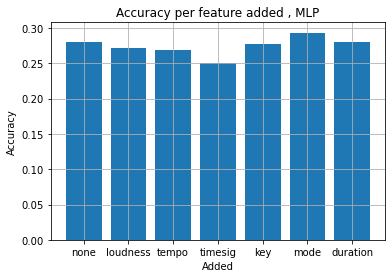

In [28]:
plt.bar(X , Acc_K1)
plt.title('Accuracy per feature added , MLP')
plt.xlabel('Added')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()